<a href="https://colab.research.google.com/github/sijiao-liu/deep_learning/blob/assignment-2/02_activities/assignments/assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [1]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

Default GPU Device: /device:GPU:0


In [2]:
def download_file(url, file_path):
    import requests
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

dataset = 'shakespeare.txt' # Other options are mark_twain.txt, charles_dickens.txt

download_file(f'https://github.com/UofT-DSI/deep_learning/raw/main/assignments/downloaded_books/' + dataset, dataset)

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
text = load_dataset(dataset, fraction=0.1)

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [2]:
import requests

# URL of the raw text file
url = "https://raw.githubusercontent.com/sijiao-liu/deep_learning/assignment-2/02_activities/assignments/downloaded_books/charles_dickens.txt"

# Fetch the data
response = requests.get(url)


In [3]:
# Check if the request was successful
if response.status_code == 200:
    text = response.text  # Get the content of the file
    print("First 1000 characters of the dataset:\n")
    print(text[:1000])

    # Report the dataset size
    dataset_size = len(text)
    print("\nDataset size (number of characters):", dataset_size)

    # Report the number of unique characters in the dataset
    unique_characters = len(set(text))
    print("Number of unique characters:", unique_characters)
else:
    print(f"Failed to fetch the file. HTTP Status Code: {response.status_code}")

First 1000 characters of the dataset:

The Project Gutenberg eBook of A Tale of Two Cities, by Charles Dickens

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: A Tale of Two Cities
       A Story of the French Revolution

Author: Charles Dickens

Release Date: January, 1994 [eBook #98]
[Most recently updated: December 20, 2020]

Language: English

Character set encoding: UTF-8

Produced by: Judith Boss and David Widger

*** START OF THE PROJECT GUTENBERG EBOOK A TALE OF TWO CITIES ***




A TALE OF TWO CITIES

A STORY OF THE FRENCH REVOLUTION

By Charles Dickens


CONTENTS


     Book the F

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Define constants
VOCAB_SIZE = 1000  # Specify an appropriate vocabulary size based on your dataset
OOV_TOKEN = "<OOV>"  # Token for out-of-vocabulary words

# 1. Convert the text to lowercase
text = text.lower()

# 2. Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts([text])  # Fit tokenizer on the text

# 3. Convert text to a sequence of numbers
sequences = tokenizer.texts_to_sequences([text])


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [5]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('the', 2), ('\r', 3), ('and', 4), ('of', 5), ('to', 6), ('a', 7), ('in', 8), ('that', 9), ('his', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [14]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# Adjustments for SEQ_LENGTH and batch processing
SEQ_LENGTH = 10  # Reduced sequence length to save memory
BATCH_SIZE = 32  # Batch size for generator

def sequence_generator(sequences, seq_length, batch_size):
    """Generate training sequences and one-hot encoded targets in batches."""
    while True:
        for i in range(0, len(sequences) - seq_length, batch_size):
            X = []
            y = []
            for j in range(batch_size):
                if i + j + seq_length < len(sequences):
                    seq = sequences[i + j:i + j + seq_length]
                    target = sequences[i + j + seq_length]
                    X.append(seq)
                    y.append(target)
            X = np.array(X)
            y = np.array(y)
            y = to_categorical(y, num_classes=VOCAB_SIZE)  # One-hot encode the targets
            yield X, y


# Convert text to sequences
sequences = tokenizer.texts_to_sequences([text])[0]

# Generate training and validation data using generator
train_gen = sequence_generator(sequences, SEQ_LENGTH, BATCH_SIZE)


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [16]:
# Test generator output
X, y = next(train_gen)

if len(X) > 0 and len(y) > 0:
    # Convert one-hot encoded target back to an integer
    target_index = np.argmax(y[0])  # Find the index of the highest value in the one-hot vector

    # Print the sequence and its target
    print(f'Sequence: {X[0]}')  # Token indices for the sequence
    print(f'Target (one-hot): {y[0]}')  # One-hot encoded target
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[target_index]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [  2 309  20  50   1   4  15 375  50   1]
Target (one-hot): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Flatten sequences and create dataset arrays
    sequences = tokenizer.texts_to_sequences([text])[0]

    # Remove sequences with OOV token
    if OOV_TOKEN in tokenizer.word_index:
        oov_index = tokenizer.word_index[OOV_TOKEN]
        sequences = [token for token in sequences if token != oov_index]

    # Generate training data using a generator
    def create_training_data(sequences, seq_length):
        X, y = [], []
        for i in range(seq_length, len(sequences)):
            seq = sequences[i - seq_length:i]
            target = sequences[i]
            X.append(seq)
            y.append(target)
        return np.array(X), np.array(y)

    # Create sequences and targets
    X, y = create_training_data(sequences, SEQ_LENGTH)

    # One-hot encode the targets
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (2448356, 10)
y_train shape: (2448356, 1000)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [19]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Define constants
EMBEDDING_DIM = 100  # Size of the dense embedding
VOCAB_SIZE = 1000  # Must match the vocabulary size used in the tokenizer

# Define the model
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=SEQ_LENGTH),
    LSTM(128, return_sequences=False),  # LSTM layer with 128 units
    Dense(VOCAB_SIZE, activation='softmax')  # Output layer with softmax activation
])

# Check the model summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 100)           100000    
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1000)              129000    
                                                                 
Total params: 346248 (1.32 MB)
Trainable params: 346248 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

In [20]:
from keras.optimizers import Adam

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Explanation:
# Loss Function: 'categorical_crossentropy' is used because this is a multi-class classification problem where the model predicts a probability distribution over the vocabulary.
# Optimizer: Adam is chosen for its efficiency and adaptive learning rates, which typically lead to faster convergence.


## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [21]:
# Create the updated training generator
train_gen = sequence_generator(sequences, SEQ_LENGTH, BATCH_SIZE)

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(sequences) // (BATCH_SIZE * SEQ_LENGTH),
    epochs=5,
    validation_data=sequence_generator(sequences, SEQ_LENGTH, BATCH_SIZE),  # Validation generator
    validation_steps=len(sequences) // (10 * BATCH_SIZE * SEQ_LENGTH)  # Reduced steps for validation
)


Epoch 1/5
9563/9563 [==============================] - 108s 11ms/step - loss: 4.6925 - accuracy: 0.1598 - val_loss: 4.8023 - val_accuracy: 0.1498
Epoch 2/5
9563/9563 [==============================] - 107s 11ms/step - loss: 4.4156 - accuracy: 0.1756 - val_loss: 4.6937 - val_accuracy: 0.1561
Epoch 3/5
9563/9563 [==============================] - 106s 11ms/step - loss: 4.4342 - accuracy: 0.1745 - val_loss: 4.6940 - val_accuracy: 0.1625
Epoch 4/5
9563/9563 [==============================] - 107s 11ms/step - loss: 4.3901 - accuracy: 0.1722 - val_loss: 4.5732 - val_accuracy: 0.1587
Epoch 5/5
9563/9563 [==============================] - 106s 11ms/step - loss: 4.2994 - accuracy: 0.1817 - val_loss: 4.6328 - val_accuracy: 0.1654


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

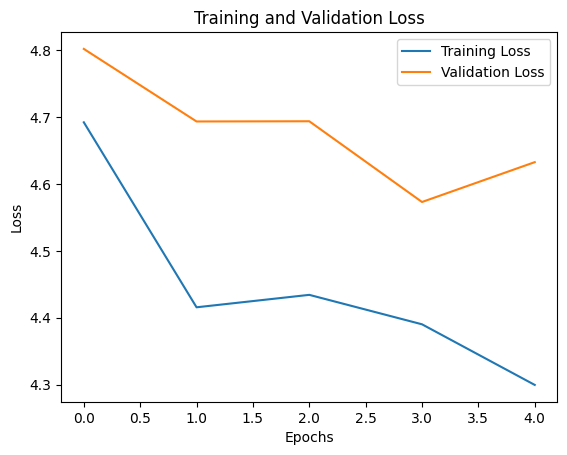

In [22]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [25]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

def get_predicted_word(model, sequence, temperature=1.0):
    """
    Get the predicted word from the model using temperature sampling.

    Parameters:
        model (keras.Model): Trained RNN model.
        sequence (numpy.ndarray): Padded sequence input.
        temperature (float): Sampling temperature; higher values increase randomness.

    Returns:
        int: Predicted token index.
    """
    # Predict probabilities for the next token
    yhat = model.predict(sequence, verbose=0)
    yhat = yhat.ravel()  # Flatten the output

    # Apply temperature scaling
    yhat = np.log(yhat + 1e-9) / temperature
    yhat = np.exp(yhat) / np.sum(np.exp(yhat))

    # Sample the next token index
    predicted_index = np.random.choice(range(len(yhat)), p=yhat)
    return predicted_index


def generate_text(model, tokenizer, seed_text, max_sequence_len, num_words=50):
    """
    Generate new text using the trained model.

    Parameters:
        model (keras.Model): Trained RNN model.
        tokenizer (Tokenizer): Tokenizer used for preprocessing.
        seed_text (str): Initial text to start generation.
        max_sequence_len (int): Maximum sequence length for input to the model.
        num_words (int): Number of words to generate.

    Returns:
        str: Generated text.
    """
    generated_text = seed_text

    for _ in range(num_words):
        # Tokenize the current seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Pad sequences to match the max_sequence_len
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')

        # Predict the next word using the model
        predicted_index = get_predicted_word(model, token_list)

        # Get the word from the predicted index
        predicted_word = tokenizer.index_word.get(predicted_index, "<OOV>")

        # Append the predicted word to the seed text
        seed_text += " " + predicted_word
        generated_text += " " + predicted_word

        # Optional: Print generated text in real-time
        print(predicted_word, end=" ", flush=True)

    print()  # For newline after real-time printing
    return generated_text



In [31]:
import numpy as np

def get_predicted_word(model, sequence, temperature=1.0):
    """
    Get the predicted word from the model using temperature sampling.

    Parameters:
        model (keras.Model): Trained RNN model.
        sequence (numpy.ndarray): Padded sequence input.
        temperature (float): Sampling temperature; higher values increase randomness.

    Returns:
        int: Predicted token index.
    """
    # Predict probabilities for the next token
    yhat = model.predict(sequence, verbose=0)
    yhat = yhat.ravel()  # Flatten the output

    # Apply temperature scaling
    yhat = np.log(yhat + 1e-9) / temperature
    yhat = np.exp(yhat) / np.sum(np.exp(yhat))

    # Sample the next token index
    predicted_index = np.random.choice(range(len(yhat)), p=yhat)
    return predicted_index

In [32]:
from keras.preprocessing.sequence import pad_sequences

def generate_text(model, tokenizer, seed_text, max_sequence_len, num_words=50):
    """
    Generate new text using the trained model.

    Parameters:
        model (keras.Model): Trained RNN model.
        tokenizer (Tokenizer): Tokenizer used for preprocessing.
        seed_text (str): Initial text to start generation.
        max_sequence_len (int): Maximum sequence length for input to the model.
        num_words (int): Number of words to generate.

    Returns:
        str: Generated text.
    """
    generated_text = seed_text

    for _ in range(num_words):
        # Tokenize the current seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Pad sequences to match the max_sequence_len
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')

        # Predict the next word using the model
        predicted_index = get_predicted_word(model, token_list)

        # Get the word from the predicted index
        predicted_word = tokenizer.index_word.get(predicted_index, "<OOV>")

        # Append the predicted word to the seed text
        seed_text += " " + predicted_word
        generated_text += " " + predicted_word

    return generated_text



In [33]:
# Test the text generation function
generated_text = generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)
print("\nGenerated Text:")
print(generated_text)


Generated Text:
 mrs a though she could wish to her in her and for her


It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small.

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras.
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [34]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2024-12-01 05:34:47--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.95MB/s    in 2m 40s  

2024-12-01 05:37:28 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [35]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [36]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [37]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

In [38]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Define a new model with pre-trained embeddings
model = Sequential([
    embedding_layer,  # Use the pre-trained embedding layer
    LSTM(128, return_sequences=True),  # First LSTM layer with return_sequences=True
    Dropout(0.2),  # Dropout for regularization
    LSTM(128),  # Second LSTM layer
    Dropout(0.2),  # Dropout for regularization
    Dense(VOCAB_SIZE, activation='softmax')  # Output layer
])

# Compile the new model
model.compile(
    optimizer='adam',  # Adam optimizer
    loss='categorical_crossentropy',  # Categorical crossentropy loss
    metrics=['accuracy']  # Track accuracy during training
)

# Print model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 100)           100000    
                                                                 
 lstm_2 (LSTM)               (None, 10, 128)           117248    
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1000)              129000    
                                                                 
Total params: 477832 (1.82 MB)
Trainable params: 37783

In [39]:
# Train the model
history = model.fit(
    train_gen,  # Use the generator for training
    steps_per_epoch=len(sequences) // (BATCH_SIZE * SEQ_LENGTH),
    validation_data=sequence_generator(sequences, SEQ_LENGTH, BATCH_SIZE),  # Validation generator
    validation_steps=len(sequences) // (10 * BATCH_SIZE * SEQ_LENGTH),
    epochs=10,  # Train for more epochs
    batch_size=128  # Experiment with different batch sizes
)


Epoch 1/10
9563/9563 [==============================] - 193s 20ms/step - loss: 4.9932 - accuracy: 0.1273 - val_loss: 4.9561 - val_accuracy: 0.1371
Epoch 2/10
9563/9563 [==============================] - 188s 20ms/step - loss: 4.7200 - accuracy: 0.1412 - val_loss: 4.5857 - val_accuracy: 0.1557
Epoch 3/10
9563/9563 [==============================] - 192s 20ms/step - loss: 4.5942 - accuracy: 0.1539 - val_loss: 4.6630 - val_accuracy: 0.1491
Epoch 4/10
9563/9563 [==============================] - 190s 20ms/step - loss: 4.5212 - accuracy: 0.1666 - val_loss: 4.4900 - val_accuracy: 0.1622
Epoch 5/10
9563/9563 [==============================] - 193s 20ms/step - loss: 4.4325 - accuracy: 0.1722 - val_loss: 4.6160 - val_accuracy: 0.1677
Epoch 6/10
9563/9563 [==============================] - 188s 20ms/step - loss: 4.4560 - accuracy: 0.1748 - val_loss: 4.2765 - val_accuracy: 0.1900
Epoch 7/10
9563/9563 [==============================] - 188s 20ms/step - loss: 4.5264 - accuracy: 0.1626 - val_loss: 4

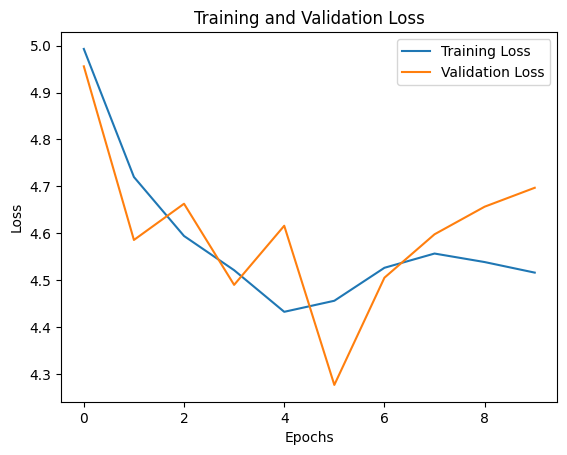

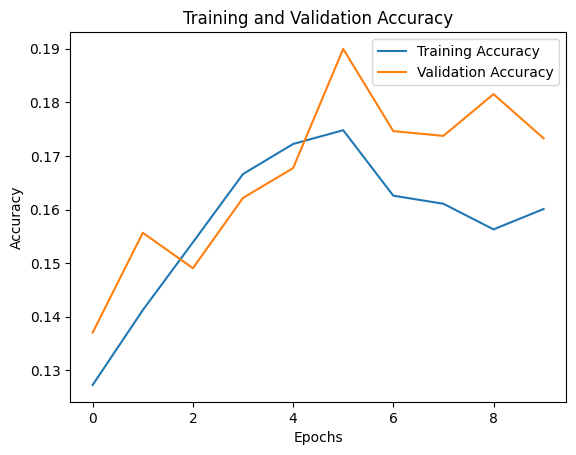

In [40]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [41]:
embedding_layer = Embedding(
    VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=True
)


In [42]:
# Test the text generation with the refined model
generated_text = generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)
print("\nGenerated Text:")
print(generated_text)



Generated Text:
 the same in some people to drink to for there he could die who


## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.